500 hPa Geopotential Heights, Absolute Vorticity, and Winds
===========================================================

Classic 500-hPa absolute vorticity plot using NAM analysis file.

This example uses example data from the NAM analysis for 12 UTC 31
October 2016 and uses xarray as the main read source with using MetPy to
calculate absolute vorticity and wind speed with geographic plotting
using Cartopy for a CONUS view of the 500-hPa geopotential heights,
absolute vorticity, and wind barbs.

Note: NAM winds are grid relative and this example introduces a simple
function to convert the grid-relative wind components to an
earth-relative (north/east oriented winds) to enable easier plotting of
wind barbs and calculation of absolute vorticity.


Import the needed modules


In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
import xarray as xr

Function to Compute Earth-Relative Winds
----------------------------------------

This function takes a data array with relevant information about the
projection of the wind component data, along with the grid-relative
components of the wind. It outputs the earth-relative components of the
wind.


In [2]:
def earth_relative_wind_components(ugrd, vgrd):
    """Calculate the north-relative components of the wind from the grid-relative
    components using Cartopy transform_vectors.

    Parameters
    ----------
        ugrd : Xarray DataArray (M, N)
            grid relative u-component of the wind
        vgrd : Xarray DataArray (M, N)
            grid relative v-component of the wind

    Returns
    -------
        unr, vnr : tuple of array-like Quantity
            The north-relative wind components in the X (East-West) and Y (North-South)
            directions, respectively.
    """
    if 'crs' not in list(ugrd.coords):
        raise ValueError('No CRS in coordinate, be sure to use the MetPy accessor parse_cf()')

    data_crs = ugrd.metpy.cartopy_crs

    x = ugrd.x.values
    y = ugrd.y.values

    xx, yy = np.meshgrid(x, y)

    ut, vt = ccrs.PlateCarree().transform_vectors(data_crs, xx, yy, ugrd.values, vgrd.values)

    uer = ut * units(ugrd.units)
    ver = vt * units(vgrd.units)

    return uer, ver


The following code reads the example data using the xarray open_dataset
function and prints the coordinate values that are associated with the
various variables contained within the file


In [3]:
ds = xr.open_dataset('https://thredds.ucar.edu/thredds/dodsC/casestudies/'
                     'python-gallery/NAM_20161031_1200.nc').metpy.parse_cf()

Data Retrieval
--------------

This code retrieves the necessary data from the file and completes some
smoothing of the geopotential height and wind fields using the SciPy
function gaussian_filter. A nicely formated valid time (vtime) variable
is also created


In [4]:
# Grab lat/lon values (NAM will be 2D)
lats = ds.lat.data
lons = ds.lon.data

# Grab x, y data and make 2D for wind component plotting because
# u- and v-components are grid relative
x = ds['u-component_of_wind_isobaric'].x
y = ds['u-component_of_wind_isobaric'].y

xx, yy = np.meshgrid(x, y)

# Grab Cartopy CRS from metadata for plotting wind barbs
datacrs = ds['u-component_of_wind_isobaric'].metpy.cartopy_crs

# Select and grab 500-hPa geopotential heights and smooth with n-point smoother
level = 500 * units.hPa
hght_500 = mpcalc.smooth_n_point(ds.Geopotential_height_isobaric.metpy.sel(
    vertical=level).squeeze(), 9, 50)

# Select and grab 500-hPa wind components
uwnd_500 = ds['u-component_of_wind_isobaric'].metpy.sel(vertical=level).squeeze()
vwnd_500 = ds['v-component_of_wind_isobaric'].metpy.sel(vertical=level).squeeze()

# Compute north-relative wind components for plotting purposes
uwnd_er, vwnd_er = earth_relative_wind_components(uwnd_500, vwnd_500)

# Smooth wind components as desired
uwnd_er = mpcalc.smooth_n_point(uwnd_er, 9, 50)
vwnd_er = mpcalc.smooth_n_point(vwnd_er, 9, 50)

# Create a clean datetime object for plotting based on time of Geopotential heights
vtime = ds.time.data[0].astype('datetime64[ms]').astype('O')

MetPy Absolute Vorticity Calculation
------------------------------------

This code first uses MetPy to calcualte the grid deltas (sign aware) to
use for derivative calculations with the funtcion
``lat_lon_grid_deltas()`` and then calculates ``absolute_vorticity()``
using the wind components, grid deltas, and latitude values.


In [5]:
# Calculate grid spacing that is sign aware to use in absolute vorticity calculation
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

# Calculate absolute vorticity from MetPy function
avor_500 = mpcalc.absolute_vorticity(uwnd_er, vwnd_er, dx, dy, lats * units.degrees,
                                     dim_order='yx')

Map Creation
------------

This next set of code creates the plot and draws contours on a Lambert
Conformal map centered on -100 E longitude. The main view is over the
CONUS with geopotential heights contoured every 60 m and absolute
vorticity colorshaded (:math:`*10^5`).


Text(1,1,'Valid Time: 2016-10-31 12:00:00')

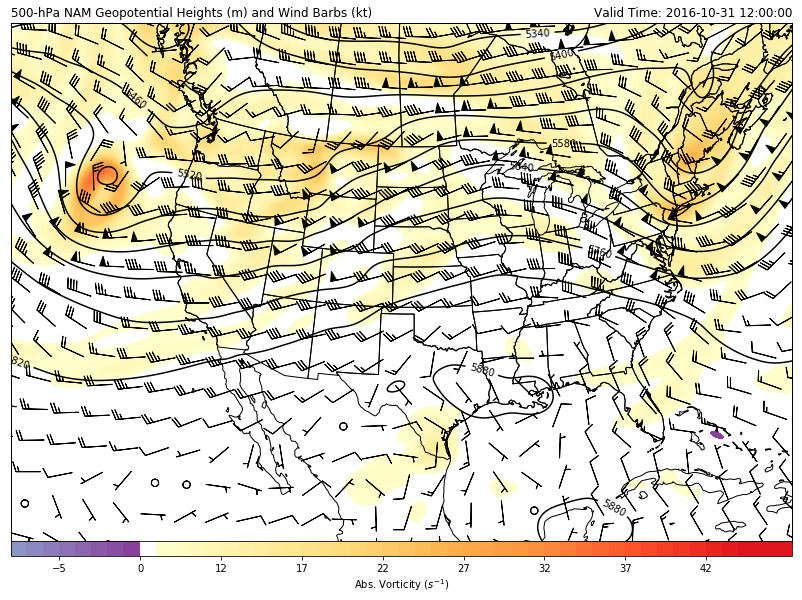

In [6]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.LambertConformal(central_longitude=-100, central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Absolute Vorticity colors
# Use two different colormaps from matplotlib and combine into one color set
clevs_500_avor = list(range(-8, 1, 1))+list(range(8, 46, 1))
colors1 = plt.cm.YlOrRd(np.linspace(0, 1, 48))
colors2 = plt.cm.BuPu(np.linspace(0.5, 0.75, 8))
colors = np.vstack((colors2, (1, 1, 1, 1), colors1))

# Plot absolute vorticity values (multiplying by 10^5 to scale appropriately)
cf = ax.contourf(lons, lats, avor_500*1e5, clevs_500_avor, colors=colors, extend='max',
                 transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50, extendrect=True)
cb.set_label('Abs. Vorticity ($s^{-1}$)')

# Plot 500-hPa Geopotential Heights in meters
clevs_500_hght = np.arange(0, 8000, 60)
cs = ax.contour(lons, lats, hght_500, clevs_500_hght, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%d')

# Set up a 2D slice to reduce the number of wind barbs plotted (every 20th)
wind_slice = (slice(None, None, 20), slice(None, None, 20))
ax.barbs(lons[wind_slice], lats[wind_slice],
         uwnd_er.to('kt')[wind_slice].m, vwnd_er[wind_slice].to('kt').m,
         pivot='middle', color='black', transform=datacrs)

# Plot two titles, one on right and left side
plt.title('500-hPa NAM Geopotential Heights (m)'
          ' and Wind Barbs (kt)', loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')